In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
from torch import (
    nn,
    Tensor
    )
from torch.nn import functional as F

# Visualize
import matplotlib.pyplot as plt


try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper


## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"
    
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class Data(helper.DataModule):
    def __init__(self, batch_size =10,T=1000,num_train=600,tau=4) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.num_train = num_train
        self.tau = tau
        self.T = T
        self.time = torch.arange(1,T+1,dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T) *0.2
    
    def get_dataloader(self, train: bool):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features,dim=1)
        self.labels = self.x[self.tau:].reshape(-1,1)
        i = slice(0,self.num_train) if train else slice(self.num_train,None)
        return self.get_tensorloader([self.features, self.labels],train,i)


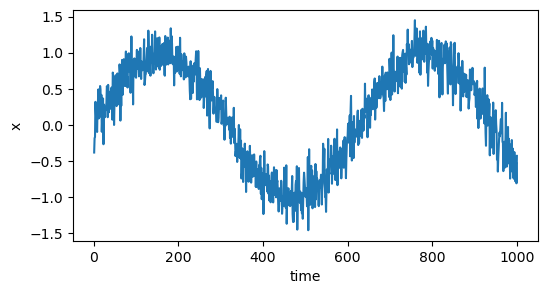

In [3]:
data = Data()
plt.figure(figsize=(6,3))
plt.plot(data.time,data.x)
plt.xlabel("time")
plt.ylabel("x");

Training the model in cpu


c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/5 [00:00<?, ?it/s]

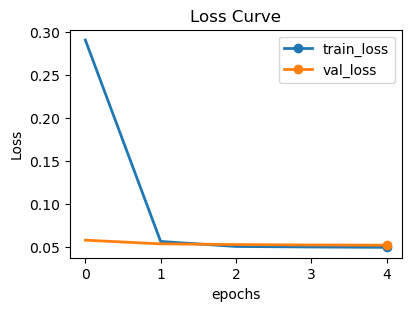

In [4]:
model = helper.LinearRegression(lr=0.01)
trainer = helper.Trainer(max_epochs=5)
trainer.fit(model,data)

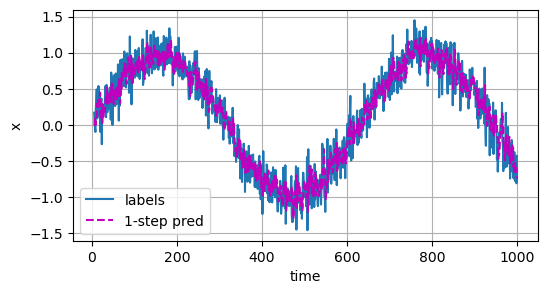

In [6]:
one_step_pred = model(data.features).detach().numpy()
helper.plot(data.time[data.tau:],[data.labels,one_step_pred],"time","x",
            legend=["labels","1-step pred"],figsize=(6,3))